In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, binarize
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn import metrics

First we read our dataset using Pandas

In [2]:
df = pd.read_csv('CrowdstormingDataJuly1st.csv')

In [3]:
df.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [4]:
df.columns

Index(['playerShort', 'player', 'club', 'leagueCountry', 'birthday', 'height',
       'weight', 'position', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'photoID', 'rater1', 'rater2',
       'refNum', 'refCountry', 'Alpha_3', 'meanIAT', 'nIAT', 'seIAT',
       'meanExp', 'nExp', 'seExp'],
      dtype='object')

From the recomended research we can use the findings of how to decrease noise in the dataset by keeping only valid interactions/dyads. We reproduce the same steps to keep referes only with 22 and more dyads.

In [5]:
Refs = df.refNum.value_counts()
validRefs = Refs[Refs>21]
df=df[df['refNum'].isin(validRefs.index.values)]

From a birthday we can create a new value age. Ages will be calculated by year 2013 but actually it does not matter.

In [6]:
df.birthday = pd.to_datetime(df.birthday)
df['age'] = 2013 - df.birthday.dt.year

We also introduce our value target value to predict by avegering scores from two raters

In [7]:
df['target'] = (df.rater1+df.rater2)/2

Drop the columns that we do not need. Also rows with missed target value

In [8]:
df.drop(['player', 'photoID', 'birthday', 'rater1', 'rater2'], inplace=True, axis=1)
df.dropna(axis=0, subset=['target'], inplace=True)

In [9]:
df.dropna(axis=0, subset=['club', 'leagueCountry', 'position'], inplace=True)
df_cat = df.groupby(['playerShort', 'club', 'leagueCountry', 'position'])['refNum'].count().reset_index()

In [10]:
df_mean = df.groupby(['playerShort'])['target', 'age', 'height',
       'weight', 'games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'meanIAT', 'nIAT',
       'meanExp', 'nExp'].mean().reset_index()

In [11]:
df_sum = df.groupby(['playerShort'])['games', 'victories', 'ties', 'defeats', 'goals',
       'yellowCards', 'yellowReds', 'redCards', 'nIAT', 'nExp'].sum().reset_index()

In [12]:
df_std = df.groupby(['playerShort'])['seIAT','seExp'].std().reset_index()

Check if the demonsionality of all derived DF are the same. And create a new merged dataset.

In [13]:
len(df_cat),len(df_mean),len(df_sum),len(df_std)

(1432, 1432, 1432, 1432)

In [14]:
df_all = df_cat.merge(df_mean,on='playerShort').merge(df_sum,on='playerShort', suffixes=['_mean', '_sum']).merge(df_std,on='playerShort')

Unfortunately sklearn implementation does not support automatic treatment for categhorical features. And as we don't have a separate test dataset we can use factorize method inbuilt in pandas for all cathegorical fields

In [15]:
df_all.club = df_all.club.factorize()[0]
df_all.leagueCountry = df_all.leagueCountry.factorize()[0]
df_all.position = df_all.position.factorize()[0]

Finally we fill the left NA with mean value per each column.

In [16]:
df_all.fillna(df_all.mean(), inplace=True)

,playerShort,club,leagueCountry,position,refNum,target,age,height,weight,games_mean,...,ties_sum,defeats_sum,goals_sum,yellowCards_sum,yellowReds_sum,redCards_sum,nIAT_sum,nExp_sum,seIAT,seExp
0,aaron-hughes,0,0,0,156,0.125,34.0,182.0,71.000000,4.108974,...,176,222,9,19,0,0,3133820.0,3281187.0,0.000707,0.003308
1,aaron-hunt,1,1,1,95,0.125,27.0,183.0,73.000000,3.463158,...,70,119,59,39,0,1,2553329.0,2627685.0,0.000508,0.002356
2,aaron-lennon,2,0,2,101,0.250,26.0,165.0,63.000000,4.079208,...,97,115,31,11,0,0,2144721.0,2246113.0,0.001220,0.008723
3,aaron-ramsey,3,0,3,98,0.000,23.0,178.0,76.000000,2.591837,...,42,67,39,31,0,1,3975720.0,4124639.0,0.001406,0.009682
4,abdelhamid-el-kaoutari,4,2,0,37,0.250,23.0,180.0,73.000000,3.351351,...,40,43,1,8,4,2,104797.0,109292.0,0.006216,0.023134
5,abdou-traore_2,5,2,2,42,0.750,25.0,180.0,74.000000,2.309524,...,23,33,3,11,1,0,189994.0,199139.0,0.011977,0.028650
6,abdoulaye-diallo_2,6,2,4,20,0.875,21.0,189.0,80.000000,1.200000,...,8,8,0,0,0,0,52934.0,55250.0,0.000269,0.001173
7,abdoulaye-keita_2,5,2,4,2,0.875,23.0,188.0,83.000000,1.500000,...,1,2,0,0,0,0,3456.0,3617.0,0.000398,0.001685
8,abdoulwhaid-sissoko,7,2,5,56,1.000,23.0,180.0,68.000000,2.160714,...,25,62,3,21,0,2,138331.0,145220.0,0.000038,0.000205
9,abdul-rahman-baba,8,1,6,27,0.875,19.0,179.0,70.000000,1.851852,...,8,25,0,3,0,1,184400.0,190059.0,0.000393,0.002305


Now we have data ready for ML. Due to the our target value discretization we need to binariese it or performe regression analyzis instead of classification.

In [17]:
features = [col for col in df_all.columns if col not in ['playerShort', 'target']]

X = df_all[features].copy()
y_reg = df_all['target'].values.reshape(-1, 1)[:,0]
y_cls = binarize(df_all['target'].values.reshape(-1, 1), threshold=0.5)[:,0]

One way to have estimation is use Out of Bag Estimates. Accroding to the documentation "This estimate comes “for free” as no additional data is needed and can be used for model selection.", also they provide a good sense of epxected general error for the unseen data.

In [18]:
rf = RandomForestClassifier(n_jobs=-1, oob_score=True, n_estimators=100, random_state=42)
rf.fit(X,y_cls)
rf.oob_score_

0.85754189944134074

85.75% is not bad!

Now we can check how different parameters effect on the accuracy. We will use 5-fold validation and first check number
of trees.

In [19]:
n_trees = [10,20,50,100,250,500,1000,2500,5000]

for n_tree in n_trees:
    rf = RandomForestClassifier(n_jobs=-1, oob_score=False, n_estimators=n_tree, random_state=42)
    accuracy = cross_val_score(rf, X, y_cls, cv=5)
    print("Accuracy for %i trees: %0.2f (+/- %0.2f)" % (n_tree, accuracy.mean(), accuracy.std() * 2))


Accuracy for 10 trees: 0.84 (+/- 0.02)
Accuracy for 20 trees: 0.86 (+/- 0.02)
Accuracy for 50 trees: 0.86 (+/- 0.02)
Accuracy for 100 trees: 0.86 (+/- 0.02)
Accuracy for 250 trees: 0.86 (+/- 0.01)
Accuracy for 500 trees: 0.86 (+/- 0.01)
Accuracy for 1000 trees: 0.86 (+/- 0.02)
Accuracy for 2500 trees: 0.86 (+/- 0.02)
Accuracy for 5000 trees: 0.86 (+/- 0.02)


Looks like 50-100 trees is enough and results are stable. Now we can check max_features param

In [20]:
fts = range(1,len(features),3)

for ft in fts:
    rf = RandomForestClassifier(n_jobs=-1, oob_score=False, n_estimators=100, random_state=42, max_features=ft)
    accuracy = cross_val_score(rf, X, y_cls, cv=5)
    print("Accuracy for %i max_features: %0.2f (+/- %0.2f)" % (ft, accuracy.mean(), accuracy.std() * 2))

Accuracy for 1 max_features: 0.85 (+/- 0.01)
Accuracy for 4 max_features: 0.85 (+/- 0.00)
Accuracy for 7 max_features: 0.86 (+/- 0.02)
Accuracy for 10 max_features: 0.86 (+/- 0.02)
Accuracy for 13 max_features: 0.85 (+/- 0.02)
Accuracy for 16 max_features: 0.86 (+/- 0.01)
Accuracy for 19 max_features: 0.86 (+/- 0.01)
Accuracy for 22 max_features: 0.86 (+/- 0.02)
Accuracy for 25 max_features: 0.86 (+/- 0.02)
Accuracy for 28 max_features: 0.85 (+/- 0.01)


Almost no difference.

What about our feature importance?

In [21]:
rf = RandomForestClassifier(n_jobs=-1, oob_score=False, n_estimators=100, random_state=42, max_features=22)
rf.fit(X,y_cls)
print (*zip(features,rf.feature_importances_))

('club', 0.037018732150814061) ('leagueCountry', 0.018300292964458183) ('position', 0.051068949187137058) ('refNum', 0.024828479766361742) ('age', 0.026062916903454903) ('height', 0.024808704920051768) ('weight', 0.025505772092156969) ('games_mean', 0.023547311869266029) ('victories_mean', 0.030318907542427373) ('ties_mean', 0.026207205035658862) ('defeats_mean', 0.0370728677352163) ('goals_mean', 0.028956719415694977) ('yellowCards_mean', 0.025604023284774593) ('yellowReds_mean', 0.019161356426366166) ('redCards_mean', 0.021616499845512189) ('meanIAT', 0.077404919009943257) ('nIAT_mean', 0.032550312738549136) ('meanExp', 0.083119073825678652) ('nExp_mean', 0.034228574917498131) ('games_sum', 0.021367062865603505) ('victories_sum', 0.019910441407770887) ('ties_sum', 0.01970342982208572) ('defeats_sum', 0.017741322465774822) ('goals_sum', 0.017995441280594011) ('yellowCards_sum', 0.0163004991117368) ('yellowReds_sum', 0.0056886108248621224) ('redCards_sum', 0.006057701832998752) ('nIAT_

They have almost the same impact a bit higher for 'position', 'victories_mean', summed 'meanIAT' and 'meanExp', and variance 'seIAT'. Not to be confused refNum represents total number of games per player. With such distiribution of weights it does not have meaning to drop out any as each of has a minor impact. Although we can remove all cathegorical variables with an assamption when skin color can be deffined purely through player to refery ineraction. Doing this we somehow remove the constants from our data as categorical data are not unique and shared between the players of one team or defined by the structure of the game itself. Hence introduce noise for the mixed color clubs and in general. 

In [22]:
features_noncat = [col for col in df_all.columns if col not in ['playerShort', 'target', 'club', 'leagueCountry', 'position']]

X_noncat= df_all[features_noncat].copy()
rf = RandomForestClassifier(n_jobs=-1, oob_score=False, n_estimators=100, random_state=42, max_features=22)
rf.fit(X_noncat,y_cls)
print (*zip(features_noncat,rf.feature_importances_))

('refNum', 0.027455877534356257) ('age', 0.029989975898591564) ('height', 0.027682216107798256) ('weight', 0.034141363956816294) ('games_mean', 0.027839810418490919) ('victories_mean', 0.035332172765975341) ('ties_mean', 0.029107003936942183) ('defeats_mean', 0.034901003305728387) ('goals_mean', 0.038217766682090974) ('yellowCards_mean', 0.027720173678412525) ('yellowReds_mean', 0.016213259060266196) ('redCards_mean', 0.025754903288031157) ('meanIAT', 0.081479401151133224) ('nIAT_mean', 0.037649462482242019) ('meanExp', 0.096063123776554807) ('nExp_mean', 0.039643586690888251) ('games_sum', 0.022172807411074805) ('victories_sum', 0.021225187373064936) ('ties_sum', 0.020001962481656029) ('defeats_sum', 0.020272411083653692) ('goals_sum', 0.026673862629173799) ('yellowCards_sum', 0.022666762945123375) ('yellowReds_sum', 0.0049388520869201773) ('redCards_sum', 0.00892379179377026) ('nIAT_sum', 0.030591870558082122) ('nExp_sum', 0.032022188825362022) ('seIAT', 0.1257500774718503) ('seExp',

Almost no difference. Variance for seIAT and seExp by plair increased their weights but not so much.

BONUS PART. Learning curves for two different sets of pararmeters.
First we try to use the best params found so far n_estimators=100 and max_features=22. We can expect stable performance with small dependency on the train size.

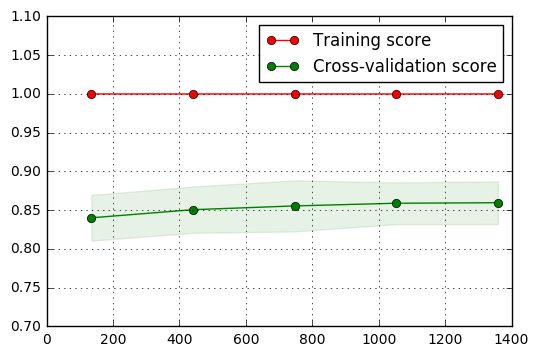

In [23]:
rf = RandomForestClassifier(oob_score=False, n_estimators=100, random_state=42, max_features=22)
train_sizes, train_scores, valid_scores = learning_curve(rf, X, y_cls, train_sizes=np.linspace(.1, 1.0, 5), 
                                                         cv=20, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
plt.grid()
plt.ylim((0.7,1.1))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.show()

Second we can try to increase the generalization of our approach by decreasign max_depth and max_features of our trees. We can also decrease number of our trees in the forest. In this case estimator becomes turned to the specific set of seen data.

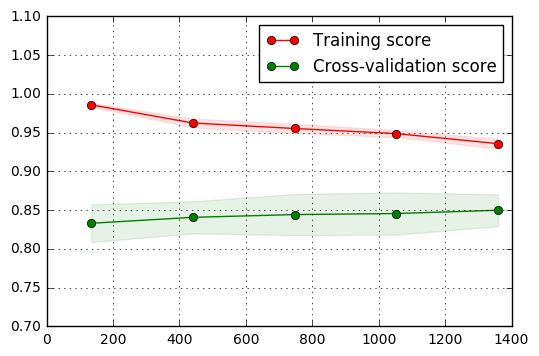

In [24]:
rf = RandomForestClassifier(oob_score=False, n_estimators=10, random_state=42, max_features=3, 
                             max_depth=10)
train_sizes, train_scores, valid_scores = learning_curve(rf, X, y_cls, train_sizes=np.linspace(.1, 1.0, 5), 
                                                         cv=20, n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)
plt.grid()
plt.ylim((0.7,1.1))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, valid_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.show()

Finally we approach the problem as regression instead of multiple-class() classification. For this case will use a grid search over different parameters.

In [25]:
parameters = {
    'n_estimators':[10,20,50,100,250,500], 
    'max_features': range(1,len(features),3),
    'min_samples_split' : [2,4,8,16,32,64],
    'min_samples_leaf' : [1,2,5,10,20,50,100],
    'max_depth' : [2,5,10,20,50,100]
}

In [26]:
rf = RandomForestRegressor()
rgr = GridSearchCV(rf, parameters, n_jobs=-1)
rgr.fit(X,y_reg)
print (rgr.best_params_)
print (rgr.best_score_)

{'min_samples_leaf': 2, 'max_features': 16, 'min_samples_split': 4, 'n_estimators': 500, 'max_depth': 20}
0.206716177754


MSE is 0.207